# Lecture 19: Convolutional Neural Networks 

In [30]:
import datetime
now = datetime.datetime.now()
print("Version: " + now.strftime("%Y-%m-%d %H:%M:%S"))

Version: 2020-03-06 09:49:27


### This Lecture 

* The basics of CNNs 
* This is a complex and very varied subject (could do a whole course on this alone)

In [31]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import tensorflow as tf

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)
    
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")
    
import warnings
warnings.filterwarnings('ignore')

## Convolutional Layers in NN 

* Convolutional neural networks (CNNs) emerged from the study of the brain’s visual cortex, and they have been used in image recognition since the 1980s.
* Used in image recognition also in voice recognition and natural language processing 
* Local Field of View
* Used to define local features in an image - data compression
<img src="Lecture19_Images/localFov.jpeg" alt="Drawing" style="width: 500px;"/>



### Why?

* A way of encoding images using a small(er) number of features upon which training (e.g. for classifying images) can take place. 
* Differences in images that enable humans to classify are hypothesise to be extracted in similar ways.

## Convolutional Layers 

* Encode convolutions as a NN 

* Neurons connected to _receptor_ field in next layer that is _smaller_. Uses zero padding to force layers to have same height & width.

* Also can connect large input layer to much smaller layer by spacing out receptor fields (distance between receptor fields is called the _stride_)

<img src="Lecture19_Images/CC.jpeg" alt="Drawing" style="width: 700px;"/>

### Feature Maps 

* Neuron weights can look like small images (w/ size = receptor field)
* Examples given: 1) vertical filter (single vertical bar, mid-image, all other cells zero) 2) horizontal filter (single horizontal bar, mid-image, all other cells zero)
* Both return _feature maps_ (highlights areas of image most similar to filter)


<img src="Lecture19_Images/featuremap.jpeg" alt="Drawing" style="width: 800px;"/>

### Stacking Feature Maps 

* More realistic to have several features of similar size i.e. 3D layers 
* A convolutional layer can thereby apply multiple filters to its input and be capable of detecting multiple features 

<img src="Lecture19_Images/stacked.jpeg" alt="Drawing" style="width: 400px;"/>


#### Example 

* The following code loads two sample images, using Scikit-Learn’s load_sample_images() (which loads two color images, one of a Chinese temple, and the other of a flower)
* Then it creates two 7 × 7 filters (one with a vertical white line in the middle, and the other with a horizontal white line in the middle), and applies them to both images using a convolutional layer built using TensorFlow’s ${\tt tf.nn.conv2d()}$ function (with zero padding and a stride of 2). 
* Finally, it plots one of the resulting feature maps



In [32]:
#simple example 
from sklearn.datasets import load_sample_image #load images

# Load sample images
china = load_sample_image("china.jpg")
flower = load_sample_image("flower.jpg")
dataset = np.array([china, flower], dtype=np.float32) #make concatenated data set
batch_size, height, width, channels = dataset.shape

# Create 2 filters that are 7x7xchannelsx2 arrays
filters = np.zeros(shape=(7, 7, channels, 2),  dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

In [33]:
# Create a graph with input X plus a convolutional layer applying the 2 filters
X = tf.placeholder(tf.float32, shape=(None, height, width, channels))

# conv2d arguments:
# x = input minibatch = 4D tensor : minibatch*height*width*channels
# filters = 4D tensor
# strides = 1D array (1, vstride, hstride, 1)
# padding = VALID = no zero padding, may ignore edge rows/cols
# padding = SAME  = zero padding used if needed
convolution = tf.nn.conv2d(X, filters, strides=[1,2,2,1], padding="VALID")

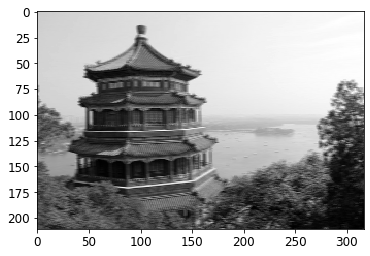

In [9]:
with tf.Session() as sess:
    output = sess.run(convolution, feed_dict={X: dataset})

#output[image_index, :, :, feature_map_index]
plt.imshow(output[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.show()

<img src="Lecture19_Images/dotproduc.png" alt="Drawing" style="width: 900px;"/>

Note the relation to the dot product 

<img src="Lecture19_Images/example.png" alt="Drawing" style="width: 900px;"/>



<img src="Lecture19_Images/6filter.png" alt="Drawing" style="width: 900px;"/>

The convolution layer comprises of a set of independent filters (6 in the example shown). Each filter is independently convolved with the image and we end up with 6 feature maps of shape 28x28x1.

<img src="Lecture19_Images/simpleseries.png" alt="Drawing" style="width: 900px;"/>

All these filters are initialized randomly and become our parameters which will be learned by the network subsequently.

<img src="Lecture19_Images/padding.jpeg" alt="Drawing" style="width: 900px;"/>



In [10]:
reset_graph()

filter_primes = np.array([2., 3., 5., 7., 11., 13.], dtype=np.float32)
x = tf.constant(np.arange(1, 13+1, dtype=np.float32).reshape([1, 1, 13, 1]))
filters = tf.constant(filter_primes.reshape(1, 6, 1, 1))

valid_conv = tf.nn.conv2d(x, filters, strides=[1, 1, 5, 1], padding='VALID')
same_conv = tf.nn.conv2d(x, filters, strides=[1, 1, 5, 1], padding='SAME')

with tf.Session() as sess:
    print("VALID:\n", valid_conv.eval())
    print("SAME:\n", same_conv.eval())


VALID:
 [[[[184.]
   [389.]]]]
SAME:
 [[[[143.]
   [348.]
   [204.]]]]


In [11]:
#the above is effectively doing a dot product of the following series with 
#the filters. Note the different behaviour that conv2 adopts in the two cases
print("VALID:")
print(np.array([1,2,3,4,5,6]).T.dot(filter_primes))
print(np.array([6,7,8,9,10,11]).T.dot(filter_primes))
print("SAME:")
print(np.array([0,1,2,3,4,5]).T.dot(filter_primes))
print(np.array([5,6,7,8,9,10]).T.dot(filter_primes))
print(np.array([10,11,12,13,0,0]).T.dot(filter_primes))

VALID:
184.0
389.0
SAME:
143.0
348.0
204.0


## Pooling Layers 

* Goal is to subsample (i.e., shrink) the input image in order to reduce the computational load, the memory usage, and the number of parameters (thereby limiting the risk of overfitting). Pooling layer operates on each feature map independently.

* Just like in convolutional layers, each neuron in a pooling layer is connected to the outputs of a limited number of neurons in the previous layer, located within a small rectangular receptive field. You must define its size, the stride, and the padding type, just like before. 

* However, a pooling neuron has no weights; all it does is aggregate the inputs using an aggregation function such as the max or mean.

<img src="Lecture19_Images/pool.jpeg" alt="Drawing" style="width: 900px;"/>

* note image is smaller due to receptive layer size

<img src="Lecture19_Images/maxpool.png" alt="Drawing" style="width: 900px;"/>



In [12]:
batch_size, height, width, channels = dataset.shape
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line
X = tf.placeholder(tf.float32, shape=(None, height, width, channels))

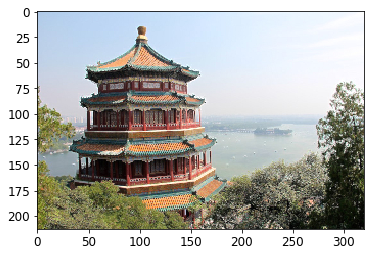

In [13]:
#The ksize argument contains the kernel shape along all four dimensions 
#of the input tensor: [batch size, height, width, channels].
max_pool = tf.nn.max_pool(X, ksize=[1,2,2,1], strides=[1,2,2,1],padding="VALID")

with tf.Session() as sess: output = sess.run(max_pool, feed_dict={X: dataset})

plt.imshow(output[0].astype(np.uint8))  # plot the output for the 1st image
plt.show()
#original
#plt.imshow(china)
#plt.show()

## CNN Architectures 

* Typical CNN architectures stack a few convolutional layers (each one generally followed by a ReLU layer; max(0,x), then a pooling layer, then another few convolutional layers (+ ReLU), then another pooling layer, and so on.

* The image gets smaller and smaller as it progresses through the network, but it also typically gets deeper and deeper (i.e., with more feature maps) thanks to the convolutional layers

* At the top of the stack, a regular feedforward neural network is added, composed of a few fully connected layers, and the final layer outputs the prediction 

<img src="Lecture19_Images/aCNN.jpeg" alt="Drawing" style="width: 1000px;"/>

<img src="Lecture19_Images/exCNN.jpeg" alt="Drawing" style="width: 1500px;"/>



#### LeNet, widely used for MNIST 

<img src="Lecture19_Images/lenet.jpeg" alt="Drawing" style="width: 500px;"/>



#### AlexNet, used for ImageNet Challenge http://www.image-net.org/challenges/LSVRC/

<img src="Lecture19_Images/alexnet.jpeg" alt="Drawing" style="width: 500px;"/>



In [14]:
# make a typical CNN architecture for the MNIST data
# trying to create a network, and train it, to recognise digits in an image
import tensorflow as tf

reset_graph()

#define dimensions of the data 
height = 28
width = 28
channels = 1
n_inputs = height * width

In [15]:
with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    
    y = tf.placeholder(tf.int32, shape=[None], name="y") #create lables 
    training = tf.placeholder_with_default(False, shape=[], name="training")

In [16]:
#define conv layer 1
conv1_fmaps = 32 #number of feature maps 
conv1_ksize = 3 #size of the kernel 
conv1_stride = 1 #stride length 
conv1_pad = "SAME" #note same so stays 28x28 

#define conv layer 2
conv2_fmaps = 64 #note: more feature because it's finer resolution
conv2_ksize = 3
conv2_stride = 1
conv2_pad = "SAME"
conv2_dropout_rate = 0.25 #pruning of zero weighted features


In [17]:
#feed reshaped X to conv1 
conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")
#feed conv1 to conv 2
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [18]:
#set 3rd pool layer feature maps size equal to 2nd conv feature maps size
pool3_fmaps = conv2_fmaps

In [19]:
#pooling layer 
with tf.name_scope("pool3"):
    #maximum over 2x2 cells
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    #reshape to be a flat layer (1D) ready for the fully connected layer 
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 14 * 14]) #factor 28/2=14 
    #prune the neurons to avoid overfitting 
    pool3_flat_drop = tf.layers.dropout(pool3_flat, conv2_dropout_rate, training=training)

Instructions for updating:
Use keras.layers.dropout instead.


In [20]:
# set up fully connected layers
n_fc1 = 128
fc1_dropout_rate = 0.5

In [21]:
#fully connected layer 
with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat_drop, n_fc1, activation=tf.nn.relu, name="fc1")
    fc1_drop = tf.layers.dropout(fc1, fc1_dropout_rate, training=training)

# Dropout: consists in randomly setting a fraction rate of input units to 0
# at each update during training time, which helps prevent overfitting. 
 
# dense: This layer implements the operation: 
# outputs = activation(inputs.kernel + bias) 
# Where activation is the activation function passed as the activation 
# argument (if not None), kernel is a weights matrix created by the layer, 
# and bias is a bias vector created by the layer (only if use_bias is True)    

Instructions for updating:
Use keras.layers.dense instead.


In [22]:
# number of final outputs
n_outputs = 10

In [23]:
#essentially computing the probability of each feature output from fc1 
#using softmax 
#softmax = tf.exp(logits) / tf.reduce_sum(tf.exp(logits), axis)
#not used, but for interest 
with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

In [24]:
#create training nodes
with tf.name_scope("train"):
    #Computes sparse softmax cross entropy between logits and labels.
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    #computes mean of the xentropy 
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    #want to minimise the loss
    training_op = optimizer.minimize(loss)

In [25]:
#evaluation nodes 
with tf.name_scope("eval"):
    #Says whether the targets are in the top K predictions.
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

#save and initialisation nodes 
with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [26]:
#--- for tensorboard ---
from datetime import datetime
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph()) #node that write the default graph
#-----------------------
# > tensorboard --logdir tf_logs/

<img src="Lecture19_Images/png.png" alt="Drawing" style="width: 500px;"/>

In [27]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [28]:
#simple DNN
X_train = mnist.train.images
X_test = mnist.test.images
y_train = mnist.train.labels.astype("int")
y_test = mnist.test.labels.astype("int")
config = tf.contrib.learn.RunConfig(tf_random_seed=42) # not shown in the config
feature_cols = tf.contrib.learn.infer_real_valued_columns_from_input(X_train)
dnn_clf = tf.contrib.learn.DNNClassifier(hidden_units=[300,100], n_classes=10,feature_columns=feature_cols, config=config)
dnn_clf = tf.contrib.learn.SKCompat(dnn_clf) # if TensorFlow >= 1.1
dnn_clf.fit(X_train, y_train, batch_size=50, steps=40000)

Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.
Instructions for updating:
Please specify feature columns explicitly.
Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please access pandas data directly.
Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please convert numpy dtypes explicitly.
Instructions for updating:
Please specify feature columns explicitly.
Instructions for updating:
Please switch to tf.contrib.estimator.*_head.
Instructions for updating:
Please replace uses of any Estimator from tf.contrib.learn with an Estimator from tf.estimator.*
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1a4d90fe50>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_maste

Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.EstimatorSpec. You can use the `estimator_spec` method to create an equivalent one.
INFO:tensorflow:Create CheckpointSaverHook.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/tz/xqtkbc315fj_whpqzk20bvvr0000gn/T/tmpuxlfkqu0/model.ckpt.
INFO:tensorflow:loss = 2.3451102, step = 1
INFO:tensorflow:global_step/sec: 239.025
INFO:tensorflow:loss = 0.3180231, step = 101 (0.419 sec)
INFO:tensorflow:global_step/sec: 333.816
INFO:tensorflow:loss = 0.30232453, step = 201 (0.300 sec)
INFO:tensorflow:global_step/sec: 319.053
INFO:tensorflow:loss = 0.3843647, step = 301 (0.313 sec)
INFO:tensorflow:global_step/sec: 344.594
INFO:tensorflow:loss = 0.2465452, step = 401 (0.290 sec)
INFO:tensorflow:g

INFO:tensorflow:loss = 0.00796658, step = 7101 (0.272 sec)
INFO:tensorflow:global_step/sec: 366.002
INFO:tensorflow:loss = 0.04186182, step = 7201 (0.273 sec)
INFO:tensorflow:global_step/sec: 357.272
INFO:tensorflow:loss = 0.0062439097, step = 7301 (0.280 sec)
INFO:tensorflow:global_step/sec: 372.963
INFO:tensorflow:loss = 0.013128574, step = 7401 (0.268 sec)
INFO:tensorflow:global_step/sec: 346.429
INFO:tensorflow:loss = 0.00646461, step = 7501 (0.289 sec)
INFO:tensorflow:global_step/sec: 354.78
INFO:tensorflow:loss = 0.02591987, step = 7601 (0.282 sec)
INFO:tensorflow:global_step/sec: 369.484
INFO:tensorflow:loss = 0.006956603, step = 7701 (0.271 sec)
INFO:tensorflow:global_step/sec: 373.876
INFO:tensorflow:loss = 0.005558961, step = 7801 (0.267 sec)
INFO:tensorflow:global_step/sec: 369.408
INFO:tensorflow:loss = 0.023308253, step = 7901 (0.271 sec)
INFO:tensorflow:global_step/sec: 364.83
INFO:tensorflow:loss = 0.0046272976, step = 8001 (0.274 sec)
INFO:tensorflow:global_step/sec: 37

INFO:tensorflow:global_step/sec: 365.805
INFO:tensorflow:loss = 0.0023779052, step = 15201 (0.273 sec)
INFO:tensorflow:global_step/sec: 330.976
INFO:tensorflow:loss = 0.0019087527, step = 15301 (0.302 sec)
INFO:tensorflow:global_step/sec: 365.464
INFO:tensorflow:loss = 0.0032258304, step = 15401 (0.274 sec)
INFO:tensorflow:global_step/sec: 374.821
INFO:tensorflow:loss = 0.0054714344, step = 15501 (0.267 sec)
INFO:tensorflow:global_step/sec: 352.445
INFO:tensorflow:loss = 0.002649191, step = 15601 (0.284 sec)
INFO:tensorflow:global_step/sec: 356.123
INFO:tensorflow:loss = 0.007692176, step = 15701 (0.281 sec)
INFO:tensorflow:global_step/sec: 353.25
INFO:tensorflow:loss = 0.0018865977, step = 15801 (0.283 sec)
INFO:tensorflow:global_step/sec: 360.746
INFO:tensorflow:loss = 0.0010239874, step = 15901 (0.277 sec)
INFO:tensorflow:global_step/sec: 362.152
INFO:tensorflow:loss = 0.0043757143, step = 16001 (0.276 sec)
INFO:tensorflow:global_step/sec: 362.899
INFO:tensorflow:loss = 0.0035236024

INFO:tensorflow:global_step/sec: 361.098
INFO:tensorflow:loss = 0.0023469187, step = 23201 (0.277 sec)
INFO:tensorflow:global_step/sec: 376.172
INFO:tensorflow:loss = 0.0015940508, step = 23301 (0.266 sec)
INFO:tensorflow:global_step/sec: 361.789
INFO:tensorflow:loss = 0.0008266786, step = 23401 (0.276 sec)
INFO:tensorflow:global_step/sec: 376.727
INFO:tensorflow:loss = 0.0007012665, step = 23501 (0.265 sec)
INFO:tensorflow:global_step/sec: 380.97
INFO:tensorflow:loss = 0.0004641424, step = 23601 (0.262 sec)
INFO:tensorflow:global_step/sec: 356.407
INFO:tensorflow:loss = 0.00023034117, step = 23701 (0.281 sec)
INFO:tensorflow:global_step/sec: 372.916
INFO:tensorflow:loss = 0.001380448, step = 23801 (0.268 sec)
INFO:tensorflow:global_step/sec: 362.935
INFO:tensorflow:loss = 0.0013015133, step = 23901 (0.276 sec)
INFO:tensorflow:global_step/sec: 374.489
INFO:tensorflow:loss = 0.0012848483, step = 24001 (0.267 sec)
INFO:tensorflow:global_step/sec: 364.253
INFO:tensorflow:loss = 0.00060663

INFO:tensorflow:global_step/sec: 363.782
INFO:tensorflow:loss = 0.00032063923, step = 31201 (0.275 sec)
INFO:tensorflow:global_step/sec: 337.713
INFO:tensorflow:loss = 0.000689139, step = 31301 (0.296 sec)
INFO:tensorflow:global_step/sec: 359.491
INFO:tensorflow:loss = 0.0008954214, step = 31401 (0.278 sec)
INFO:tensorflow:global_step/sec: 351.395
INFO:tensorflow:loss = 0.0005241038, step = 31501 (0.284 sec)
INFO:tensorflow:global_step/sec: 336.906
INFO:tensorflow:loss = 0.00027110855, step = 31601 (0.297 sec)
INFO:tensorflow:global_step/sec: 360.958
INFO:tensorflow:loss = 0.00082513987, step = 31701 (0.277 sec)
INFO:tensorflow:global_step/sec: 340.036
INFO:tensorflow:loss = 0.0003177952, step = 31801 (0.294 sec)
INFO:tensorflow:global_step/sec: 335.744
INFO:tensorflow:loss = 0.00081833213, step = 31901 (0.298 sec)
INFO:tensorflow:global_step/sec: 342.298
INFO:tensorflow:loss = 0.00022702658, step = 32001 (0.292 sec)
INFO:tensorflow:global_step/sec: 363.745
INFO:tensorflow:loss = 0.000

INFO:tensorflow:loss = 0.0008412306, step = 39101 (0.267 sec)
INFO:tensorflow:global_step/sec: 380.662
INFO:tensorflow:loss = 0.00037995476, step = 39201 (0.263 sec)
INFO:tensorflow:global_step/sec: 379.681
INFO:tensorflow:loss = 0.00019879454, step = 39301 (0.263 sec)
INFO:tensorflow:global_step/sec: 381.618
INFO:tensorflow:loss = 0.00032485332, step = 39401 (0.262 sec)
INFO:tensorflow:global_step/sec: 376.263
INFO:tensorflow:loss = 0.00022632975, step = 39501 (0.266 sec)
INFO:tensorflow:global_step/sec: 376.323
INFO:tensorflow:loss = 0.0003924902, step = 39601 (0.266 sec)
INFO:tensorflow:global_step/sec: 378.934
INFO:tensorflow:loss = 0.000120283046, step = 39701 (0.264 sec)
INFO:tensorflow:global_step/sec: 370.906
INFO:tensorflow:loss = 0.0011964233, step = 39801 (0.270 sec)
INFO:tensorflow:global_step/sec: 361.539
INFO:tensorflow:loss = 0.001347187, step = 39901 (0.277 sec)
INFO:tensorflow:Saving checkpoints for 40000 into /var/folders/tz/xqtkbc315fj_whpqzk20bvvr0000gn/T/tmpuxlfkqu

SKCompat()

In [29]:
n_epochs = 10
batch_size = 100

with tf.Session() as sess:
    init.run() #initalise 
    for epoch in range(n_epochs): #loop over epochs
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        
        #pass through the training data through the network (optimisation performed)
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        #then pass training data through the same network 
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

        save_path = saver.save(sess, "./my_mnist_model")

0 Train accuracy: 0.99 Test accuracy: 0.9848
1 Train accuracy: 0.98 Test accuracy: 0.9839
2 Train accuracy: 0.99 Test accuracy: 0.9879
3 Train accuracy: 1.0 Test accuracy: 0.9885
4 Train accuracy: 1.0 Test accuracy: 0.9872
5 Train accuracy: 0.99 Test accuracy: 0.9902


KeyboardInterrupt: 

#### No Exercise! But encouraged to look at examples closely 

* 1) Understand the MNIST example above, annotate this yourself and attempt to run it (note it will take some time)  
* 2) Attempt to draw (by hand, or otherwise the CNN architecture) - will not be marked 
* 3) What could you do if you encounter memory problems with this network?
* 4) Look at the example below, and comment on the differences

In [ ]:
def cnn_model_fn(features, labels, mode):
    """Model function for CNN."""
    # Input Layer
    input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Dense Layer
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

    # Logits Layer
    logits = tf.layers.dense(inputs=dropout, units=10)

    predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    train_op = optimizer.minimize(
        loss=loss,
        global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [ ]:
# Load training and eval data
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
train_data = mnist.train.images # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
eval_data = mnist.test.images # Returns np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)

In [ ]:
# Create the Estimator
mnist_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn, model_dir="/tmp/mnist_convnet_model")

In [ ]:
# Set up logging for predictions
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
tensors=tensors_to_log, every_n_iter=50)

In [ ]:
# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=train_labels,
    batch_size=100,
    num_epochs=None,
    shuffle=True)
mnist_classifier.train(
    input_fn=train_input_fn,
    steps=20000,
    hooks=[logging_hook])

In [ ]:
# Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data},
    y=eval_labels,
    num_epochs=1,
    shuffle=False)
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)